# Goal of this notebook:

### The goal of this notebook is investigate the accuracy of DNN model for predicting any one of the top three horses(place betting) in any kinds of race hold by HKJC without any feature generation and hyperparameters tuning.

# Flow

#### 1) df was created by combining 'races' and 'runs'

#### 2) df was splited into X_train, X_test, y_train, y_test before imputation to avoid any overfitting and data leakage

#### 3) The missing values in splited dataframes were being imputed with MissForesstExtra(XGBClassifer)

#### 4) Those splited dataframes were turned into torch.tensors

#### 5) Different DNN were built and trained and evaluated with those splited dataframes

#### 6) The best precision achieved were 0.7116 and 0.7137for trainset and testset respectively

#### 7) Underfitting occurs, so we might need to increase the number of features to avoid it

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
races = pd.read_csv("races.csv", delimiter=",", header=0, index_col='race_id')
races.reset_index(inplace=True)
runs = pd.read_csv("runs.csv", delimiter=",", header=0)

In [8]:
races.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6349 entries, 0 to 6348
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   race_id             6349 non-null   int64  
 1   date                6349 non-null   object 
 2   venue               6349 non-null   object 
 3   race_no             6349 non-null   int64  
 4   config              6349 non-null   object 
 5   surface             6349 non-null   int64  
 6   distance            6349 non-null   int64  
 7   going               6349 non-null   object 
 8   horse_ratings       6349 non-null   object 
 9   prize               5887 non-null   float64
 10  race_class          6349 non-null   int64  
 11  sec_time1           6349 non-null   float64
 12  sec_time2           6349 non-null   float64
 13  sec_time3           6349 non-null   float64
 14  sec_time4           3634 non-null   float64
 15  sec_time5           821 non-null    float64
 16  sec_ti

In [9]:
runs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79447 entries, 0 to 79446
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   race_id          79447 non-null  int64  
 1   horse_no         79447 non-null  int64  
 2   horse_id         79447 non-null  int64  
 3   result           79447 non-null  int64  
 4   won              79447 non-null  float64
 5   lengths_behind   79447 non-null  float64
 6   horse_age        79447 non-null  int64  
 7   horse_country    79445 non-null  object 
 8   horse_type       79445 non-null  object 
 9   horse_rating     79447 non-null  int64  
 10  horse_gear       79447 non-null  object 
 11  declared_weight  79447 non-null  float64
 12  actual_weight    79447 non-null  int64  
 13  draw             79447 non-null  int64  
 14  position_sec1    79447 non-null  int64  
 15  position_sec2    79447 non-null  int64  
 16  position_sec3    79447 non-null  int64  
 17  position_sec

In [10]:
races.shape, runs.shape

((6349, 37), (79447, 37))

In [11]:
# selecting neccessary features and combining "runs" and "races" dataframes
df = pd.merge(runs[['race_id', 'draw', 'horse_age', 'horse_country', 'horse_type', 'horse_rating', 'declared_weight', 'actual_weight', 'win_odds', 'result']], 
              races[['race_id', 'venue', 'config', 'surface', 'distance', 'going', 'race_class']], on='race_id')

# since "race_id" is useless for our model, we are going to drop it
df.drop('race_id', axis=1, inplace=True)

In [12]:
df.shape

(79447, 15)

In [13]:
df.isnull().sum().sort_values(ascending=False)

horse_country      2
horse_type         2
draw               0
horse_age          0
horse_rating       0
declared_weight    0
actual_weight      0
win_odds           0
result             0
venue              0
config             0
surface            0
distance           0
going              0
race_class         0
dtype: int64

In [14]:
# check if features "horse_country" and "horse_type" are numerical or categorical
print(df['horse_country'].sample(1))
print(df['horse_type'].sample(1))

19637    NZ
Name: horse_country, dtype: object
30149    Gelding
Name: horse_type, dtype: object


In [15]:
# as our model will only address the "place" betting, our model only need to which horses are within the top 3 or not
def top3(row):
    if row > 3:
        return 0
    else:
        return 1
    
df['result'] = df['result'].apply(top3)

In [16]:
X = df.drop('result', axis=1)
y = df['result']

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [18]:
for dataframe in [X_train, X_test, y_train, y_test]:
    print(dataframe.shape)

(55612, 14)
(23835, 14)
(55612,)
(23835,)


In [19]:
X_train.isnull().sum()

draw               0
horse_age          0
horse_country      1
horse_type         1
horse_rating       0
declared_weight    0
actual_weight      0
win_odds           0
venue              0
config             0
surface            0
distance           0
going              0
race_class         0
dtype: int64

In [20]:
X_test.isnull().sum()

draw               0
horse_age          0
horse_country      1
horse_type         1
horse_rating       0
declared_weight    0
actual_weight      0
win_odds           0
venue              0
config             0
surface            0
distance           0
going              0
race_class         0
dtype: int64

In [21]:
# MissForest: non-parametric imputation method
from MissForestExtra import MissForestExtra
mf = MissForestExtra()

In [22]:
# import a ML model for MissForestExtra
from xgboost import XGBClassifier
xgbc = XGBClassifier(use_label_encoder=False)

In [23]:
# since the amount of missing values in "horse_country" and "horse_type" are the same, 
# it doesn't matter which feature to impute first
X_train['horse_country'] = mf.impute(X_train, 'horse_country', xgbc)
X_test['horse_country'] = mf.impute(X_test, 'horse_country', xgbc)

X_train['horse_type'] = mf.impute(X_train, 'horse_type', xgbc)
X_test['horse_type'] = mf.impute(X_test, 'horse_type', xgbc)

[21:46:59] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:47:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:47:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror'

<ipython-input-23-79e9f2f79de9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['horse_country'] = mf.impute(X_train, 'horse_country', xgbc)


[21:47:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:47:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror'

<ipython-input-23-79e9f2f79de9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['horse_country'] = mf.impute(X_test, 'horse_country', xgbc)


[21:48:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror'

<ipython-input-23-79e9f2f79de9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['horse_type'] = mf.impute(X_train, 'horse_type', xgbc)


[21:48:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:47] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:51] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror'

<ipython-input-23-79e9f2f79de9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['horse_type'] = mf.impute(X_test, 'horse_type', xgbc)


In [24]:
X_train.isnull().sum()

draw               0
horse_age          0
horse_country      0
horse_type         0
horse_rating       0
declared_weight    0
actual_weight      0
win_odds           0
venue              0
config             0
surface            0
distance           0
going              0
race_class         0
dtype: int64

In [25]:
X_test.isnull().sum()

draw               0
horse_age          0
horse_country      0
horse_type         0
horse_rating       0
declared_weight    0
actual_weight      0
win_odds           0
venue              0
config             0
surface            0
distance           0
going              0
race_class         0
dtype: int64

In [26]:
# custom nested for loop to perform label encoding
for dataframe in [X_train, X_test]:
    for feat in ['horse_country', 'horse_type', 'venue', 'going', 'config']:
        dataframe[feat].replace(dataframe[feat].unique(), range(dataframe[feat].nunique()), inplace=True)

X_train[['horse_country', 'horse_type', 'venue', 'going', 'config']].head()

/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,horse_country,horse_type,venue,going,config
67372,0,0,0,0,0
5651,0,0,1,0,1
49,1,1,0,1,1
49758,0,0,1,1,2
54937,2,0,0,2,3


# Exploratory Data Analysis

In [27]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

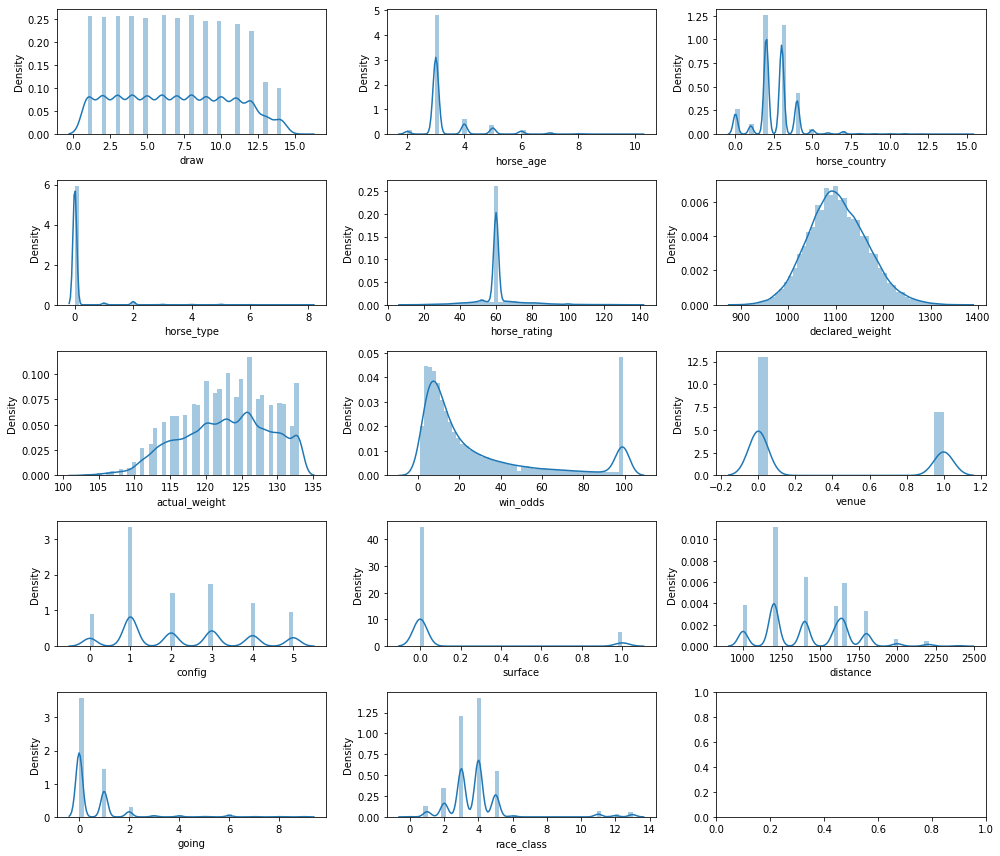

In [28]:
fig, ax = plt.subplots(5, 3, figsize=(14, 12))
ax = ax.flatten()
for idx, col in enumerate(X_train.columns):
    sns.distplot(X_train[col], ax=ax[idx])
    plt.tight_layout()

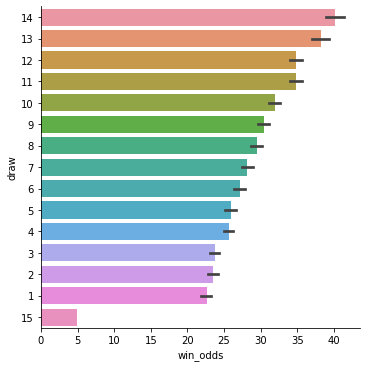

In [29]:
order = df.groupby('draw').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='draw', x='win_odds', kind='bar', orient='h', order=order)
plt.show()

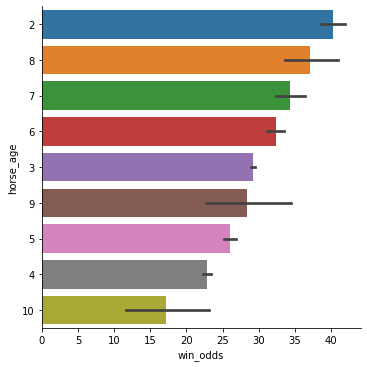

In [30]:
order = df.groupby('horse_age').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='horse_age', x='win_odds', kind='bar', orient='h', order=order)
plt.show()

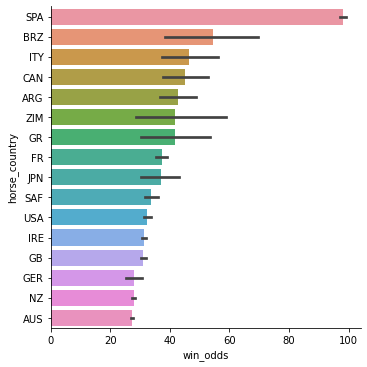

In [31]:
order = df.groupby('horse_country').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='horse_country', x='win_odds', kind='bar', orient='h', order=order)
plt.show()

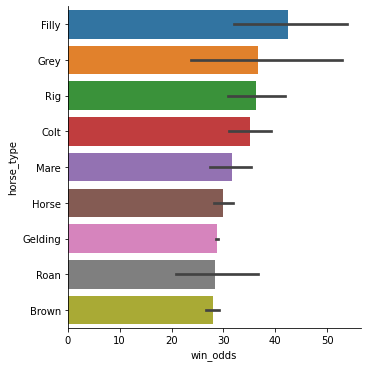

In [32]:
order = df.groupby('horse_type').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='horse_type', x='win_odds', kind='bar', orient='h', order=order)
plt.show()

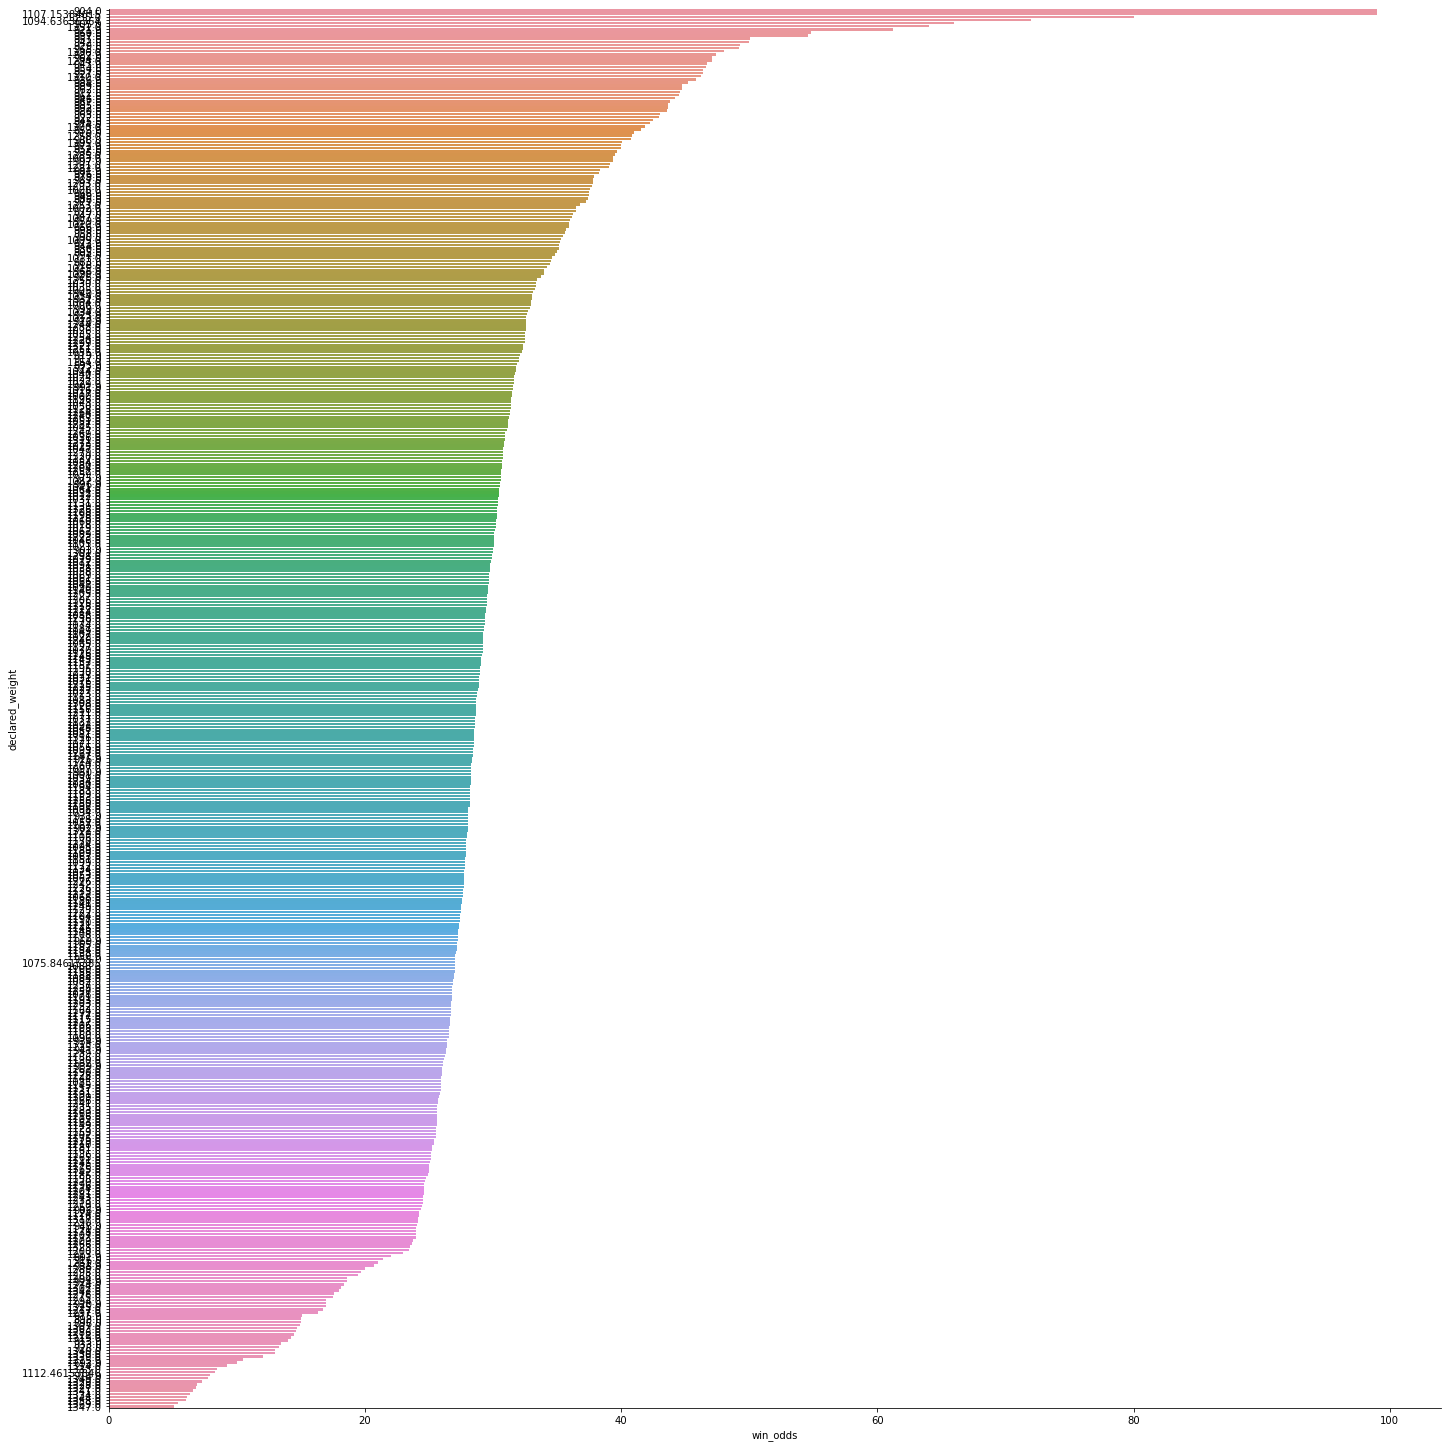

In [33]:
order = df.groupby('declared_weight').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='declared_weight', x='win_odds', kind='bar', orient='h', order=order, height=20, ci=None)
plt.show()

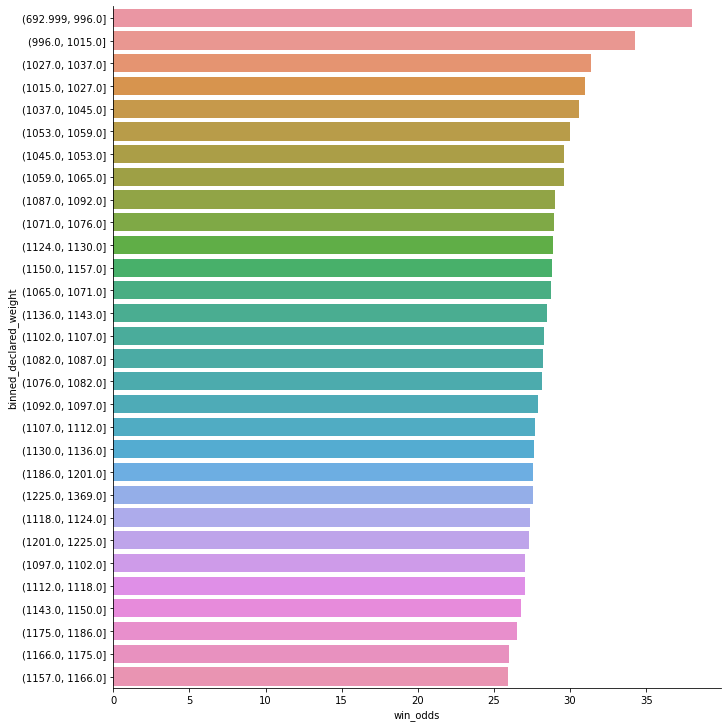

In [34]:
df['binned_declared_weight'] = pd.qcut(df['declared_weight'], q=30)
order = df.groupby('binned_declared_weight').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='binned_declared_weight', x='win_odds', kind='bar', orient='h', order=order, ci=None, height=10)
plt.show()

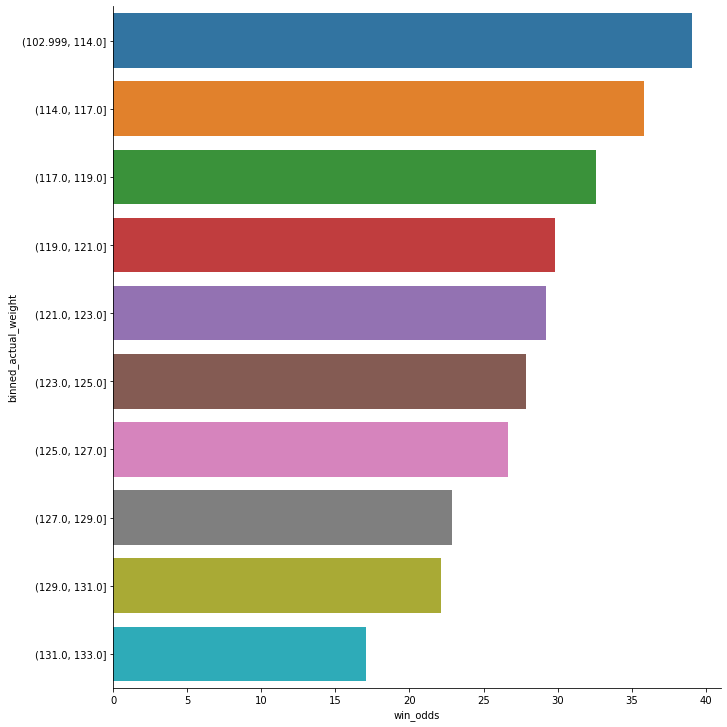

In [35]:
df['binned_actual_weight'] = pd.qcut(df['actual_weight'], q=10)
order = df.groupby('binned_actual_weight').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='binned_actual_weight', x='win_odds', kind='bar', orient='h', order=order, ci=None, height=10)
plt.show()

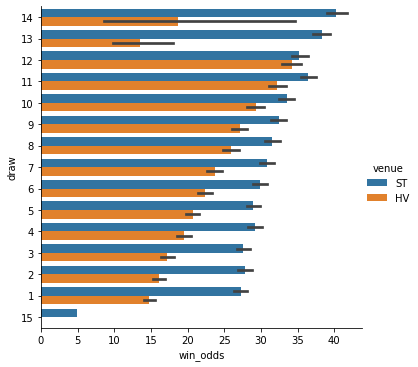

In [36]:
order = df.groupby('draw').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='draw', x='win_odds', hue='venue', kind='bar', orient='h', order=order)
plt.show()

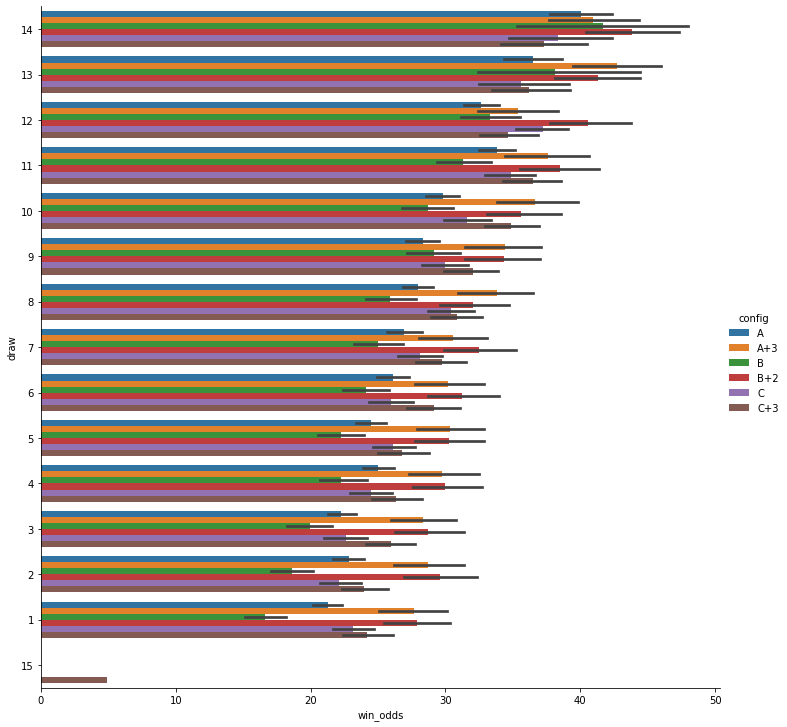

In [37]:
order = df.groupby('draw').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='draw', x='win_odds', hue='config', kind='bar', orient='h', order=order, height=10)
plt.show()

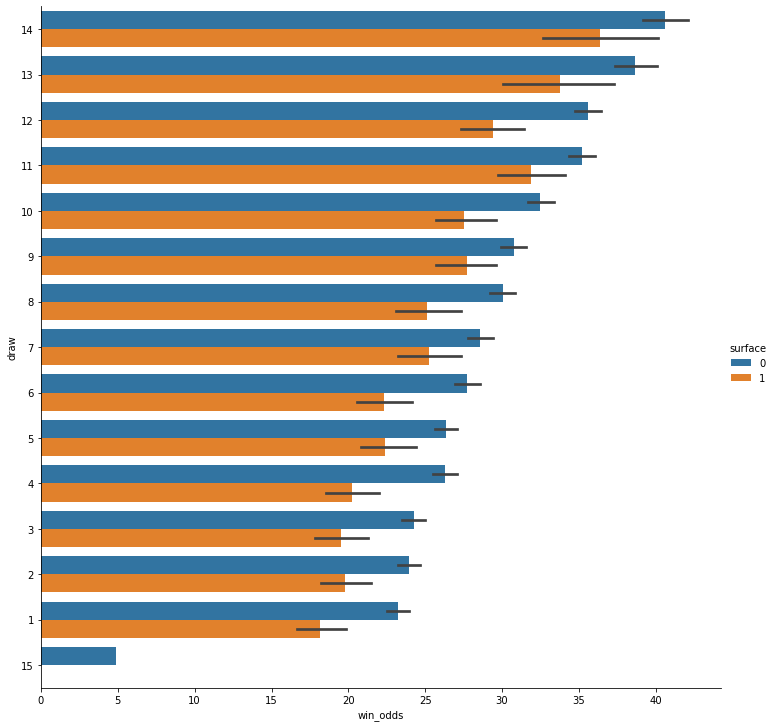

In [38]:
order = df.groupby('draw').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='draw', x='win_odds', hue='surface', kind='bar', orient='h', order=order, height=10)
plt.show()

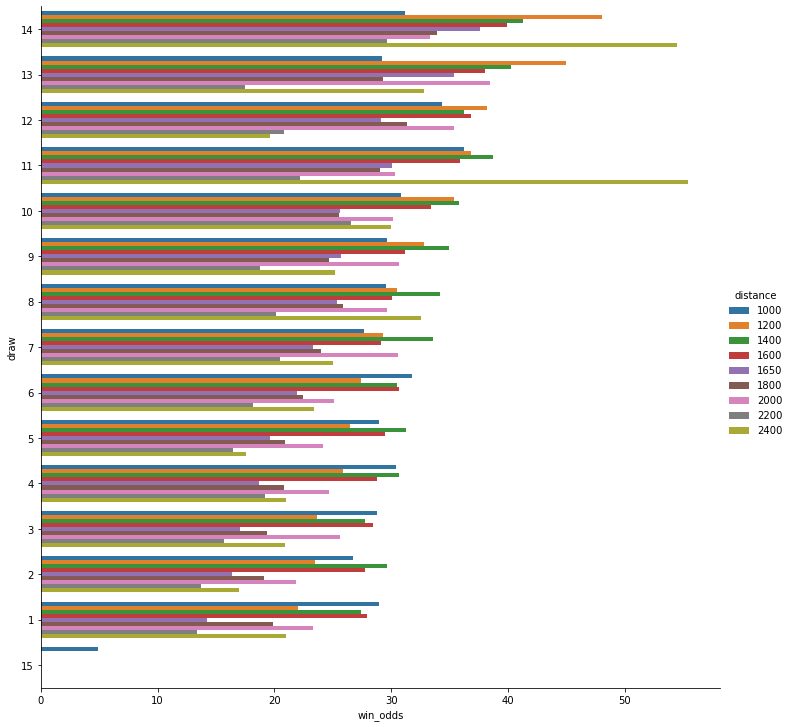

In [39]:
order = df.groupby('draw').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='draw', x='win_odds', hue='distance', kind='bar', orient='h', order=order, height=10, ci=None)
plt.show()

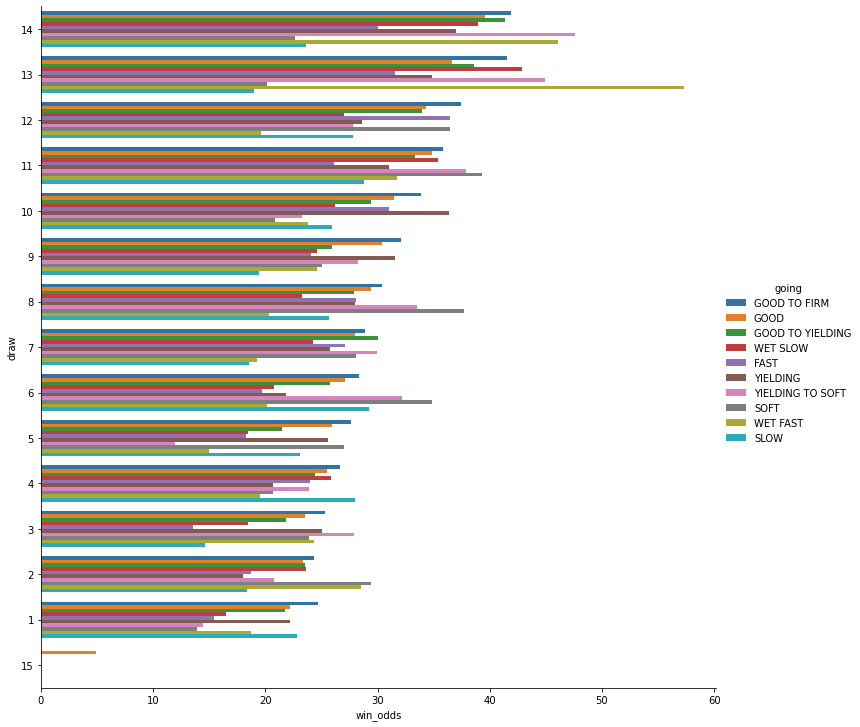

In [40]:
order = df.groupby('draw').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='draw', x='win_odds', hue='going', kind='bar', orient='h', order=order, height=10, ci=None)
plt.show()

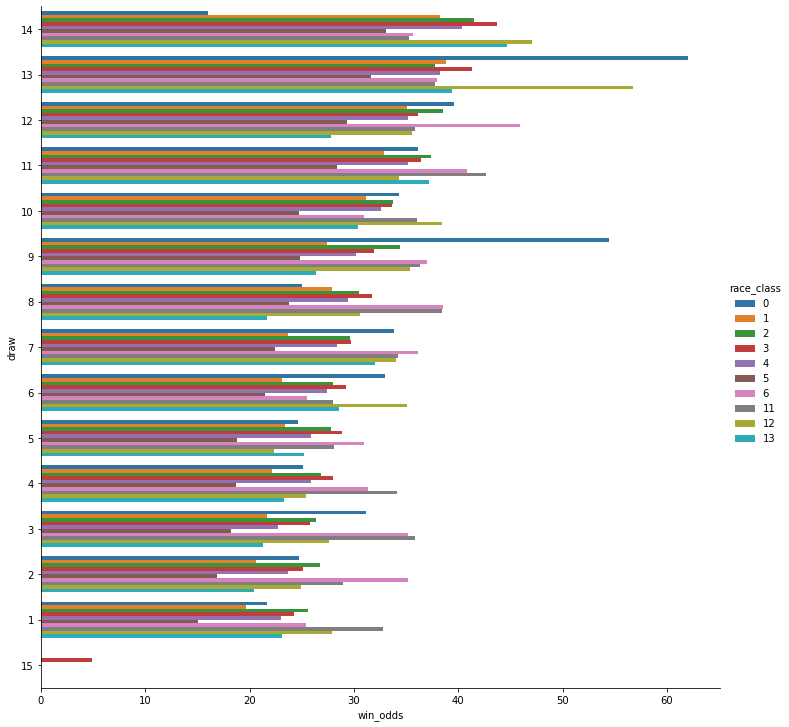

In [41]:
order = df.groupby('draw').mean()['win_odds'].sort_values(ascending=False).index
sns.catplot(data=df, y='draw', x='win_odds', hue='race_class', kind='bar', orient='h', order=order, height=10, ci=None)
plt.show()

In [42]:
# Scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [43]:
X_train = np.array(X_train.astype(np.float32))
y_train = np.array(y_train.astype(np.float32))
X_test = np.array(X_test.astype(np.float32))
y_test = np.array(y_test.astype(np.float32))

In [44]:
import torch
from torch import nn

In [45]:
# Convert data into torch tensors
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy((y_train).reshape(-1, 1))
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy((y_test).reshape(-1, 1))

In [46]:
N, D = X_train.shape

In [47]:
# Build the model
model = nn.Sequential(
    nn.Linear(D, 1),
    nn.ReLU(),
    nn.Sigmoid()
)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

In [72]:
def train_model(X_train, y_train, X_test, y_test, model):

    # Train the model
    n_epochs = 1000

    # Stuff to store
    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)

    for it in range(n_epochs):
        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Get test loss
        outputs_test = model(X_test)
        loss_test = criterion(outputs_test, y_test)

        # Save losses
        train_losses[it] = loss.item()
        test_losses[it] = loss_test.item()

        if (it + 1) % 50 == 0:
            print(f'Epoch {it+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {loss_test.item():.4f}')
            
    # Plot the train loss and test loss per iteration
    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='test loss')
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    sns.despine()
    plt.show()

    # Get accuracy
    with torch.no_grad():
        p_train = model(X_train)
        p_train = np.round(p_train.numpy())
        train_acc = np.mean(y_train.numpy() == p_train)
        train_precision = precision_score(y_train.numpy(), p_train, average='macro')
        
        p_test = model(X_test)
        p_test = np.round(p_test.numpy())
        test_acc = np.mean(y_test.numpy() == p_test)
        test_precision = precision_score(y_test.numpy(), p_test, average='macro')
    print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}, Train pre: {train_precision:.4f}, Test pre: {test_precision:.4f}")
            
    return train_losses, test_losses, model

Epoch 50/1000, Train Loss: 0.6894, Test Loss: 0.6899
Epoch 100/1000, Train Loss: 0.6894, Test Loss: 0.6899
Epoch 150/1000, Train Loss: 0.6894, Test Loss: 0.6899
Epoch 200/1000, Train Loss: 0.6894, Test Loss: 0.6899
Epoch 250/1000, Train Loss: 0.6894, Test Loss: 0.6899
Epoch 300/1000, Train Loss: 0.6894, Test Loss: 0.6899
Epoch 350/1000, Train Loss: 0.6894, Test Loss: 0.6899
Epoch 400/1000, Train Loss: 0.6894, Test Loss: 0.6899
Epoch 450/1000, Train Loss: 0.6894, Test Loss: 0.6899
Epoch 500/1000, Train Loss: 0.6894, Test Loss: 0.6899
Epoch 550/1000, Train Loss: 0.6894, Test Loss: 0.6899
Epoch 600/1000, Train Loss: 0.6894, Test Loss: 0.6899
Epoch 650/1000, Train Loss: 0.6894, Test Loss: 0.6899
Epoch 700/1000, Train Loss: 0.6894, Test Loss: 0.6899
Epoch 750/1000, Train Loss: 0.6894, Test Loss: 0.6899
Epoch 800/1000, Train Loss: 0.6894, Test Loss: 0.6899
Epoch 850/1000, Train Loss: 0.6893, Test Loss: 0.6899
Epoch 900/1000, Train Loss: 0.6893, Test Loss: 0.6899
Epoch 950/1000, Train Loss: 0

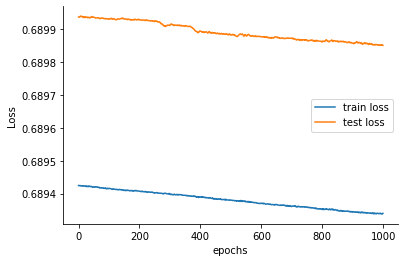

Train acc: 0.7808, Test acc: 0.7810, Train pre: 0.6991, Test pre: 0.6982


In [73]:
train_losses, test_losses, model = train_model(X_train, y_train, X_test, y_test, model)

train acc < test acc: Underfitting

Epoch 50/1000, Train Loss: 0.6893, Test Loss: 0.6899
Epoch 100/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 150/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 200/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 250/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 300/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 350/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 400/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 450/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 500/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 550/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 600/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 650/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 700/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 750/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 800/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 850/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 900/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 950/1000, Train Loss: 0

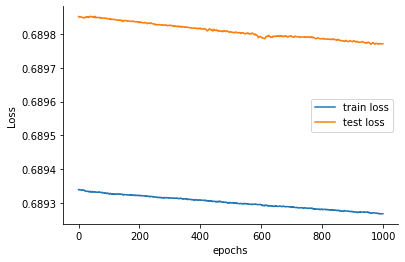

Train acc: 0.7813, Test acc: 0.7819, Train pre: 0.7012, Test pre: 0.7018


In [95]:
# second model
model2 = nn.Sequential(
    nn.Linear(D, 7),
    nn.ReLU(),
    nn.Linear(7, 1),
    nn.ReLU(),
    nn.Sigmoid()
)

train_losses2, test_losses2, model2 = train_model(X_train, y_train, X_test, y_test, model)

train acc > test acc: slight overfitting

Epoch 50/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 100/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 150/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 200/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 250/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 300/1000, Train Loss: 0.6893, Test Loss: 0.6898
Epoch 350/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 400/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 450/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 500/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 550/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 600/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 650/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 700/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 750/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 800/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 850/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 900/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 950/1000, Train Loss: 0

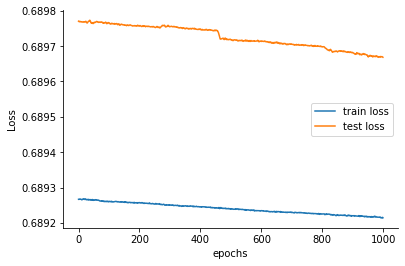

Train acc: 0.7813, Test acc: 0.7820, Train pre: 0.7026, Test pre: 0.7032


In [96]:
# third model
model3 = nn.Sequential(
    nn.Linear(D, int(D * 0.7)),
    nn.ReLU(),
    nn.Linear(int(D * 0.7), int(D * 0.4)),
    nn.ReLU(),
    nn.Linear(int(D * 0.4), 1),
    nn.ReLU(),
    nn.Sigmoid()
)

train_losses3, test_losses3, model3 = train_model(X_train, y_train, X_test, y_test, model)

Epoch 50/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 100/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 150/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 200/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 250/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 300/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 350/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 400/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 450/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 500/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 550/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 600/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 650/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 700/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 750/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 800/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 850/1000, Train Loss: 0.6892, Test Loss: 0.6897
Epoch 900/1000, Train Loss: 0.6892, Test Loss: 0.6896
Epoch 950/1000, Train Loss: 0

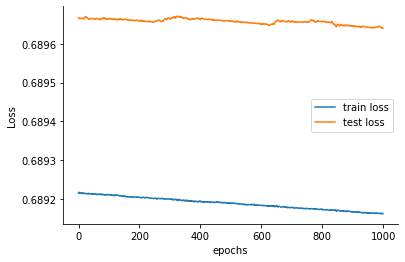

Train acc: 0.7811, Test acc: 0.7825, Train pre: 0.7037, Test pre: 0.7073


In [97]:
# fourth model
model4 = nn.Sequential(
    nn.Linear(D, int(D * 0.75)),
    nn.ReLU(),
    nn.Linear(int(D * 0.75), int(D * 0.5)),
    nn.ReLU(),
    nn.Linear(int(D * 0.5), int(D * 0.25)),
    nn.ReLU(),
    nn.Linear(int(D * 0.25), 1),
    nn.ReLU(),
    nn.Sigmoid()
)

train_losses4, test_losses4, model4 = train_model(X_train, y_train, X_test, y_test, model)

Epoch 50/1000, Train Loss: 0.6892, Test Loss: 0.6896
Epoch 100/1000, Train Loss: 0.6892, Test Loss: 0.6896
Epoch 150/1000, Train Loss: 0.6892, Test Loss: 0.6896
Epoch 200/1000, Train Loss: 0.6892, Test Loss: 0.6896
Epoch 250/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 300/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 350/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 400/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 450/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 500/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 550/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 600/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 650/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 700/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 750/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 800/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 850/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 900/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 950/1000, Train Loss: 0

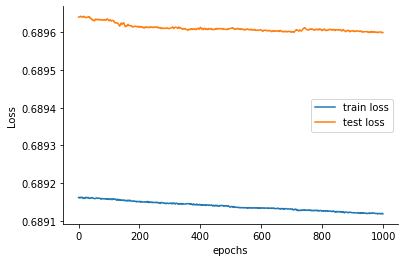

Train acc: 0.7813, Test acc: 0.7825, Train pre: 0.7054, Test pre: 0.7085


In [98]:
# fifth model
model5 = nn.Sequential(
    nn.Linear(D, int(D * 0.8)),
    nn.ReLU(),
    nn.Linear(int(D * 0.8), int(D * 0.6)),
    nn.ReLU(),
    nn.Linear(int(D * 0.6), int(D * 0.4)),
    nn.ReLU(),
    nn.Linear(int(D * 0.4), int(D * 0.2)),
    nn.ReLU(),
    nn.Linear(int(D * 0.2), 1),
    nn.ReLU(),
    nn.Sigmoid()
)

train_losses5, test_losses5, model5 = train_model(X_train, y_train, X_test, y_test, model)

1) test acc goes backward

2) overfitting 

In [99]:
# Score so far
train_acc = [0.7593, 0.7686, 0.7728, 0.7757, 0.7770]
test_acc = [0.7601, 0.7682, 0.7729, 0.7761, 0.7758]

acc = pd.DataFrame([train_acc, test_acc], index=['train acc', 'test acc']).T
acc

,train acc,test acc
0,0.7593,0.7601
1,0.7686,0.7682
2,0.7728,0.7729
3,0.7757,0.7761
4,0.7770,0.7758


In [100]:
idx = np.argmax(acc['test acc']) + 1
print(f'model{idx} is the best model so far.')

model4 is the best model so far.


# Try to add dropout layer

Epoch 50/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 100/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 150/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 200/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 250/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 300/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 350/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 400/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 450/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 500/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 550/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 600/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 650/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 700/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 750/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 800/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 850/1000, Train Loss: 0.6891, Test Loss: 0.6895
Epoch 900/1000, Train Loss: 0.6891, Test Loss: 0.6895
Epoch 950/1000, Train Loss: 0

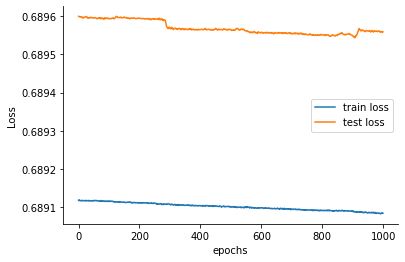

Train acc: 0.7807, Test acc: 0.7823, Train pre: 0.7055, Test pre: 0.7098


In [101]:
# fourth model with 0.5 drop out rate
model4_do = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(D, int(D * 0.75)),
    nn.ReLU(),
    nn.Linear(int(D * 0.75), int(D * 0.5)),
    nn.ReLU(),
    nn.Linear(int(D * 0.5), int(D * 0.25)),
    nn.ReLU(),
    nn.Linear(int(D * 0.25), 1),
    nn.ReLU(),
    nn.Sigmoid()
)

train_losses4_do, test_losses4_do, model4_do = train_model(X_train, y_train, X_test, y_test, model)

Epoch 50/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 100/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 150/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 200/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 250/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 300/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 350/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 400/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 450/1000, Train Loss: 0.6891, Test Loss: 0.6896
Epoch 500/1000, Train Loss: 0.6891, Test Loss: 0.6895
Epoch 550/1000, Train Loss: 0.6891, Test Loss: 0.6895
Epoch 600/1000, Train Loss: 0.6891, Test Loss: 0.6895
Epoch 650/1000, Train Loss: 0.6891, Test Loss: 0.6895
Epoch 700/1000, Train Loss: 0.6891, Test Loss: 0.6895
Epoch 750/1000, Train Loss: 0.6891, Test Loss: 0.6895
Epoch 800/1000, Train Loss: 0.6891, Test Loss: 0.6895
Epoch 850/1000, Train Loss: 0.6891, Test Loss: 0.6895
Epoch 900/1000, Train Loss: 0.6891, Test Loss: 0.6895
Epoch 950/1000, Train Loss: 0

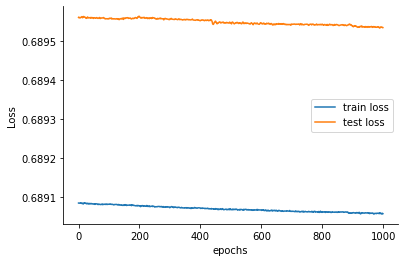

Train acc: 0.7810, Test acc: 0.7818, Train pre: 0.7073, Test pre: 0.7090


In [102]:
# fourth model with 0.4 drop out rate
model4_do = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(D, int(D * 0.75)),
    nn.ReLU(),
    nn.Linear(int(D * 0.75), int(D * 0.5)),
    nn.ReLU(),
    nn.Linear(int(D * 0.5), int(D * 0.25)),
    nn.ReLU(),
    nn.Linear(int(D * 0.25), 1),
    nn.ReLU(),
    nn.Sigmoid()
)

train_losses4_do, test_losses4_do, model4_do = train_model(X_train, y_train, X_test, y_test, model)

0.4 is even better than 0.5

Epoch 50/1000, Train Loss: 0.6891, Test Loss: 0.6895
Epoch 100/1000, Train Loss: 0.6891, Test Loss: 0.6895
Epoch 150/1000, Train Loss: 0.6891, Test Loss: 0.6895
Epoch 200/1000, Train Loss: 0.6891, Test Loss: 0.6895
Epoch 250/1000, Train Loss: 0.6891, Test Loss: 0.6895
Epoch 300/1000, Train Loss: 0.6891, Test Loss: 0.6895
Epoch 350/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 400/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 450/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 500/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 550/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 600/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 650/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 700/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 750/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 800/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 850/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 900/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 950/1000, Train Loss: 0

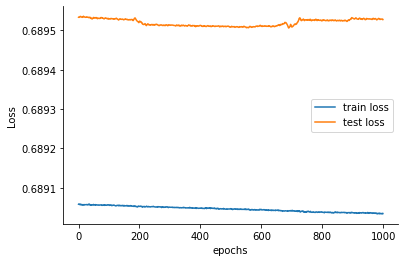

Train acc: 0.7808, Test acc: 0.7817, Train pre: 0.7079, Test pre: 0.7104


In [103]:
# fourth model with 0.3 drop out rate
model4_do = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(D, int(D * 0.75)),
    nn.ReLU(),
    nn.Linear(int(D * 0.75), int(D * 0.5)),
    nn.ReLU(),
    nn.Linear(int(D * 0.5), int(D * 0.25)),
    nn.ReLU(),
    nn.Linear(int(D * 0.25), 1),
    nn.ReLU(),
    nn.Sigmoid()
)

train_losses4_do, test_losses4_do, model4_do = train_model(X_train, y_train, X_test, y_test, model)

0.3 is even better than 0.4

Epoch 50/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 100/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 150/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 200/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 250/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 300/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 350/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 400/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 450/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 500/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 550/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 600/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 650/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 700/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 750/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 800/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 850/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 900/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 950/1000, Train Loss: 0

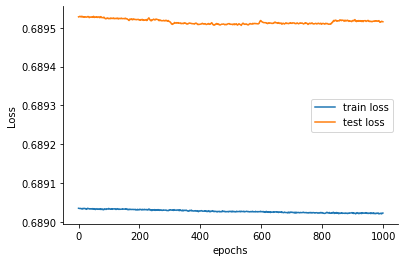

Train acc: 0.7810, Test acc: 0.7816, Train pre: 0.7094, Test pre: 0.7109


In [104]:
# fourth model with 0.2 drop out rate
model4_do = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(D, int(D * 0.75)),
    nn.ReLU(),
    nn.Linear(int(D * 0.75), int(D * 0.5)),
    nn.ReLU(),
    nn.Linear(int(D * 0.5), int(D * 0.25)),
    nn.ReLU(),
    nn.Linear(int(D * 0.25), 1),
    nn.ReLU(),
    nn.Sigmoid()
)

train_losses4_do, test_losses4_do, model4_do = train_model(X_train, y_train, X_test, y_test, model)

0.2 is even better than 0.3

Epoch 50/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 100/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 150/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 200/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 250/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 300/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 350/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 400/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 450/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 500/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 550/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 600/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 650/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 700/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 750/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 800/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 850/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 900/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 950/1000, Train Loss: 0

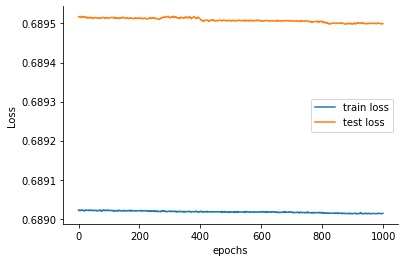

Train acc: 0.7809, Test acc: 0.7816, Train pre: 0.7099, Test pre: 0.7118


In [105]:
# fourth model with 0.1 drop out rate
model4_do = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(D, int(D * 0.75)),
    nn.ReLU(),
    nn.Linear(int(D * 0.75), int(D * 0.5)),
    nn.ReLU(),
    nn.Linear(int(D * 0.5), int(D * 0.25)),
    nn.ReLU(),
    nn.Linear(int(D * 0.25), 1),
    nn.ReLU(),
    nn.Sigmoid()
)

train_losses4_do, test_losses4_do, model4_do = train_model(X_train, y_train, X_test, y_test, model)

1) 0.1 is even better than 0.2

2) underfitting occurs

Epoch 50/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 100/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 150/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 200/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 250/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 300/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 350/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 400/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 450/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 500/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 550/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 600/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 650/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 700/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 750/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 800/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 850/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 900/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 950/1000, Train Loss: 0

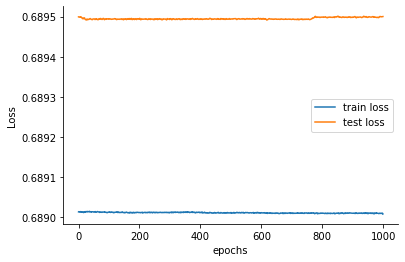

Train acc: 0.7809, Test acc: 0.7812, Train pre: 0.7103, Test pre: 0.7109


In [106]:
# fourth model with 0.05 drop out rate
model4_do = nn.Sequential(
    nn.Dropout(0.05),
    nn.Linear(D, int(D * 0.75)),
    nn.ReLU(),
    nn.Linear(int(D * 0.75), int(D * 0.5)),
    nn.ReLU(),
    nn.Linear(int(D * 0.5), int(D * 0.25)),
    nn.ReLU(),
    nn.Linear(int(D * 0.25), 1),
    nn.ReLU(),
    nn.Sigmoid()
)

train_losses4_do, test_losses4_do, model4_do = train_model(X_train, y_train, X_test, y_test, model)

1) 0.05 is even better than 0.1

Epoch 50/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 100/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 150/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 200/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 250/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 300/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 350/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 400/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 450/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 500/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 550/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 600/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 650/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 700/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 750/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 800/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 850/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 900/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 950/1000, Train Loss: 0

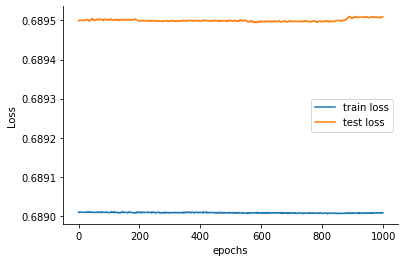

Train acc: 0.7810, Test acc: 0.7814, Train pre: 0.7111, Test pre: 0.7120


In [107]:
# fourth model with 0.025 drop out rate
model4_do = nn.Sequential(
    nn.Dropout(0.025),
    nn.Linear(D, int(D * 0.75)),
    nn.ReLU(),
    nn.Linear(int(D * 0.75), int(D * 0.5)),
    nn.ReLU(),
    nn.Linear(int(D * 0.5), int(D * 0.25)),
    nn.ReLU(),
    nn.Linear(int(D * 0.25), 1),
    nn.ReLU(),
    nn.Sigmoid()
)

train_losses4_do, test_losses4_do, model4_do = train_model(X_train, y_train, X_test, y_test, model)

1) 0.025 is even better than 0.05

Epoch 50/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 100/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 150/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 200/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 250/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 300/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 350/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 400/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 450/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 500/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 550/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 600/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 650/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 700/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 750/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 800/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 850/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 900/1000, Train Loss: 0.6890, Test Loss: 0.6895
Epoch 950/1000, Train Loss: 0

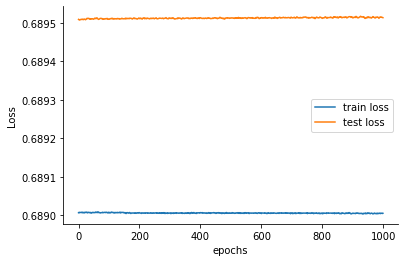

Train acc: 0.7811, Test acc: 0.7817, Train pre: 0.7116, Test pre: 0.7137


In [108]:
# fourth model with 0.0125 drop out rate
model4_do = nn.Sequential(
    nn.Dropout(0.0125),
    nn.Linear(D, int(D * 0.75)),
    nn.ReLU(),
    nn.Linear(int(D * 0.75), int(D * 0.5)),
    nn.ReLU(),
    nn.Linear(int(D * 0.5), int(D * 0.25)),
    nn.ReLU(),
    nn.Linear(int(D * 0.25), 1),
    nn.ReLU(),
    nn.Sigmoid()
)

train_losses4_do, test_losses4_do, model4_do = train_model(X_train, y_train, X_test, y_test, model)

In [4]:
# acc with do so far
train_acc = [0.7807, 0.7810, 0.7808, 0.7810, 0.7809, 0.7809, 0.7810, 0.7811]
test_acc = [0.7823, 0.7818, 0.7817, 0.7816, 0.7816, 0.7812, 0.7814, 0.7817]
train_pre = [0.7055, 0.7073, 0.7079, 0.7094, 0.7099, 0.7103, 0.7111, 0.7116]
test_pre = [0.7098, 0.7090, 0.7104, 0.7109, 0.7118, 0.7109, 0.7120, 0.7137]

score = pd.DataFrame([train_acc, test_acc, train_pre, test_pre], index=['train acc', 'test acc', 'train pre', 'test pre']).T
score

,train acc,test acc,train pre,test pre
0,0.7807,0.7823,0.7055,0.7098
1,0.7810,0.7818,0.7073,0.7090
2,0.7808,0.7817,0.7079,0.7104
3,0.7810,0.7816,0.7094,0.7109
4,0.7809,0.7816,0.7099,0.7118
5,0.7809,0.7812,0.7103,0.7109
6,0.7810,0.7814,0.7111,0.7120
7,0.7811,0.7817,0.7116,0.7137


In [8]:
idx = np.argmax(score['test pre']) + 1
print(f'model{idx} is the best model so far.')

model8 is the best model so far.


# Since underfitting occurs, we might try to increase the number of features and also try a more complicated model. 